# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import os

from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# -#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test, mode='test', cocoapi_loc=os.path.join('..', '..', 'Data'))

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

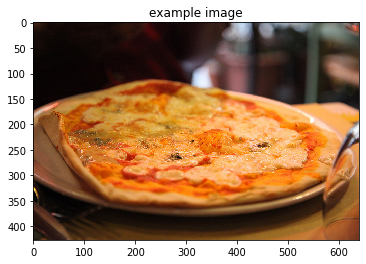

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-deploy.pkl'
decoder_file = 'decoder-deploy.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('.', 'models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('.', 'models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder = encoder.to(device)
decoder = decoder.to(device)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

conditions = ['Output needs to be a Python list!',
              'Output should be a list of integers!',
              'Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary!']

assert (type(output) == list), conditions[0]
assert all([type(x) == int for x in output]), conditions[1]
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), conditions[2]

example output: [0, 3, 2051, 21, 3, 210, 13, 1485, 39, 46, 18, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
import inspect

from data_loader import CoCoDataset

# TODO #4: Complete the function.
print(inspect.getsource(CoCoDataset.clean_sentence))

    def clean_sentence(self, output):
        """
        Generates a human readable sentence from a list of word indices that represent an image caption

        Parameters
        ----------
        output : list
            The word indices that represent an image caption

        Returns
        -------
        str:
            The human readable sentence generated from the word indices
        """
        # get the words from the indices and fix end of sentence
        words = [self.vocab.idx2word[idx] for idx in output]
        words = words[1:-1] if words[-2] == '.' else words[1:-1] + ['.']

        # humanize the sentence
        sentence = words[0]
        if len(words) > 1:
            punctuation = ['.', ',', ':', ';']
            for idx in torch.arange(len(words[1:])):
                sentence += words[int(idx+1)] if words[int(idx+1)] in punctuation else ' {}'.format(words[int(idx+1)])

        # return the sentence
        return sentence.capitalize()



After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
sentence = data_loader.dataset.clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence) == str, 'Sentence needs to be a Python string!'

example sentence: A pizza with a lot of cheese on it.


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [8]:
def get_prediction(data_loader, encoder, decoder, device):
    """
    Displays the caption generated for a random test image

    Parameters
    ----------
    data_loader : torchvision.DataLoader
        The data loader with test samples
    encoder : torch.nn.Module
        The encoder convolutional neural network
    decoder : torch.nn.Module
        The decoder recurrent neural network
    device : torch.nn.Device
        The device used to generate inferences

    Returns
    -------
        The caption generated for a random test image
    """
    with torch.no_grad():
        orig_image, image = next(iter(data_loader))
        image = image.to(device)
        features = encoder(image).unsqueeze(1)
        output = decoder.sample(features)
        sentence = data_loader.dataset.clean_sentence(output)

    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    print(sentence)

    return sentence

Run the code cell below (multiple times, if you like!) to test how this function works.

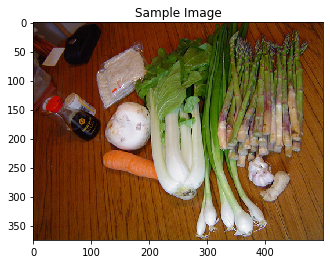

A plate of food with a variety of vegetables.


In [9]:
sentence = get_prediction(data_loader, encoder, decoder, device)

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

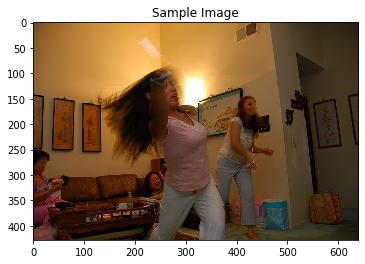

A woman is standing in a room with a wii remote.


In [10]:
sentence = get_prediction(data_loader, encoder, decoder, device)

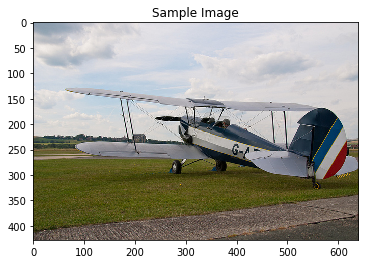

A small plane is parked on the grass.


In [11]:
sentence = get_prediction(data_loader, encoder, decoder, device)

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

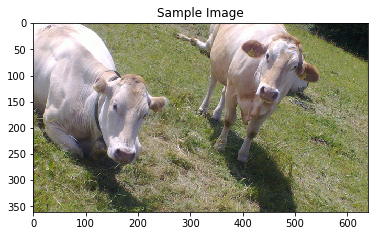

A cow is standing in the grass near a fence.


In [12]:
sentence = get_prediction(data_loader, encoder, decoder, device)

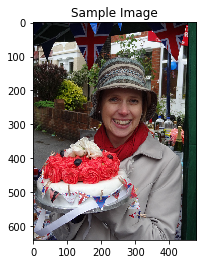

A woman is holding a stuffed animal in her hand.


In [13]:
sentence = get_prediction(data_loader, encoder, decoder, device)

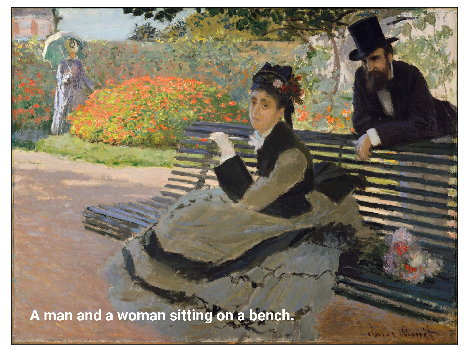

In [14]:
from PIL import Image, ImageDraw, ImageFont

# Test it outside COCO dataset (http://en.wikipedia.org/wiki/Claude_Monet)
filename = os.path.join('.', 'images', 'camille_monet_on_a_garden_bench.jpg')
fontname = os.path.join('.', 'fonts', 'Roboto-Bold.ttf')

with torch.no_grad():
    orig_image = Image.open(filename).convert('RGB')
    image = transform_test(orig_image).unsqueeze(0).to(device)
    features = encoder(image).unsqueeze(0)    
    output = decoder.sample(features)
    sentence = data_loader.dataset.clean_sentence(output)

fig, ax = plt.subplots(figsize=(8, 12))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

draw = ImageDraw.Draw(orig_image)
draw.text((80, 1280), sentence, fill='rgb(255, 255, 255)', font=ImageFont.truetype(fontname, size=64))
plt.imshow(np.squeeze(orig_image))
fig.savefig(filename[:-4] + '_cvnd_sample.png', dpi=200, transparent=True, bbox_inches="tight")
plt.show()